# DTSA 5510 Final Project

## Imports

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from itertools import permutations

# old imports
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

# latest imports
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from langdetect import detect

from textblob import TextBlob

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

## Data import

In [2]:
# data import
reviews = pd.read_csv('data/reviews.csv')

# Basic data cleaning

In [3]:
# here is an initial view of a sample of rows in the dataset
reviews.sample(5)

,ID,REVIEW_DATE,IS_VERIFIED,RATING,REVIEW_TITLE,REVIEW_TEXT,NAME
6869,8271321,2018-04-07,True,1,:Look at the picture - You can see how thin th...,This chair is a ripoff - DO NOT BUY. First off...,United States
6912,1244482,2020-08-06,True,3,"Tearable, not terrible",My bag ripped on the side seam the first night...,Canada
8740,3395647,2013-05-13,True,4,recommended to me by my md,experiencing hair loss after recent bariatric ...,United States
1930,823675,2010-12-17,True,5,please pay attention to this product,Since using Iodoral the lumps in my neck have ...,United States
3696,7459826,2019-03-19,True,5,So far so good,The basic test of a smoke alarm is how effecti...,United States


In [4]:
# From the sample dataframe above, the 'NAME' field is misleading, it will be changed from 'NAME' to 'COUNTRY'
reviews.rename(columns={'NAME': 'COUNTRY'}, inplace = True)

In [5]:
# there are 10,000 reviews in our initial dataset.
# The 'REVIEW_TITLE' column has one null entry which we will remove in a subsequent cell
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            10000 non-null  int64 
 1   REVIEW_DATE   10000 non-null  object
 2   IS_VERIFIED   10000 non-null  bool  
 3   RATING        10000 non-null  int64 
 4   REVIEW_TITLE  9999 non-null   object
 5   REVIEW_TEXT   10000 non-null  object
 6   COUNTRY       10000 non-null  object
dtypes: bool(1), int64(2), object(4)
memory usage: 478.6+ KB


In [6]:
# Identifying the only row with a null value. Since we really care about the 'REVIEW_TEXT'
# this row could probably be left in but I will remove it just to be safe
reviews[reviews['REVIEW_TITLE'].isnull()]
reviews.dropna(subset = ['REVIEW_TITLE'], axis = 0, inplace = True)

In [7]:
# double checking that there are no more null values in the updated dataset
reviews.isnull().sum()

ID              0
REVIEW_DATE     0
IS_VERIFIED     0
RATING          0
REVIEW_TITLE    0
REVIEW_TEXT     0
COUNTRY         0
dtype: int64

In [8]:
reviews.head()

,ID,REVIEW_DATE,IS_VERIFIED,RATING,REVIEW_TITLE,REVIEW_TEXT,COUNTRY
0,3129911,2022-08-17,True,1,This has NO flavor,"This item has no flavor, several people have t...",United States
1,2702184,2022-06-07,True,1,Different formula,I have used this brand of sunscreen for about ...,United States
2,760128,2014-06-03,True,5,Vitex!!!,Have been using these for at least 20 months a...,United States
3,760140,2013-11-24,True,5,Stopping hair loss,Bought this to help fight hair loss along with...,United States
4,760132,2014-04-10,True,5,coming off of birth control,this company is one of the best most honest i'...,United States


In [9]:
# There are two more adjustments that need to be made. The 'REVIEW_DATE' column should be a datetime
# also the 'ID' field should be an object
reviews['REVIEW_DATE'] = pd.to_datetime(reviews['REVIEW_DATE'])
reviews['ID'] = reviews['ID'].astype(object)

## Removing non-english reviews

There is another issue that will impact our results later on in the model testing phase. Even though these reviews are sourced from Amazon.com, there are reviews that are in different languages. A mask will be created to filter our all non English reviews.

In [10]:
# The langdetect package can be used to detect the language of a body of text.
# the package can then be used in a basic function to return the particular language of the review.
def detect_language(text):
    try:
        lang = detect(text)
    except:
        lang = 'unknown'
    return lang

In [11]:
# Running the 'REVIEW_TEXT' column of our dataset through the detect_language function from above
reviews['LANGUAGE'] = reviews['REVIEW_TEXT'].apply(detect_language)

In [12]:
# Here are the results of the  we can see that there are 
reviews['LANGUAGE'].value_counts()

LANGUAGE
en         9602
es          104
de           75
ja           63
fr           58
it           34
pt           11
af            9
ca            8
no            7
ro            6
nl            4
so            4
id            2
et            2
da            2
sl            2
tl            2
cy            2
unknown       1
hu            1
Name: count, dtype: int64

In [13]:
# Example of a portuguese review in the dataset
pd.set_option('display.max_colwidth', None)
reviews['REVIEW_TEXT'][reviews['LANGUAGE'] == 'pt'].head(1)

1925    Está muito diferente do normal. É o segundo Whey Protein Gold Standard de Baunilha que compro com este vendedor. O primeiro estava ok. Esse no entanto tem como data de vencimento Agosto de 2023, e o produto está com características estranhas, não possui a mesma viscosidade e o mesmo sabor. Se eu não conseguir substituir terei que jogar fora, pois me parece impróprio para ser consumido.
Name: REVIEW_TEXT, dtype: object

In [14]:
english_mask = reviews['LANGUAGE'] == 'en'
english_reviews = reviews[english_mask]

In [15]:
english_reviews['word_count'] = english_reviews['REVIEW_TEXT'].apply(lambda x: len(x.split()))

/var/folders/lr/994tkpld58q9sbf0jsds90h80000gn/T/ipykernel_12766/1936066079.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_reviews['word_count'] = english_reviews['REVIEW_TEXT'].apply(lambda x: len(x.split()))


## Visualizations

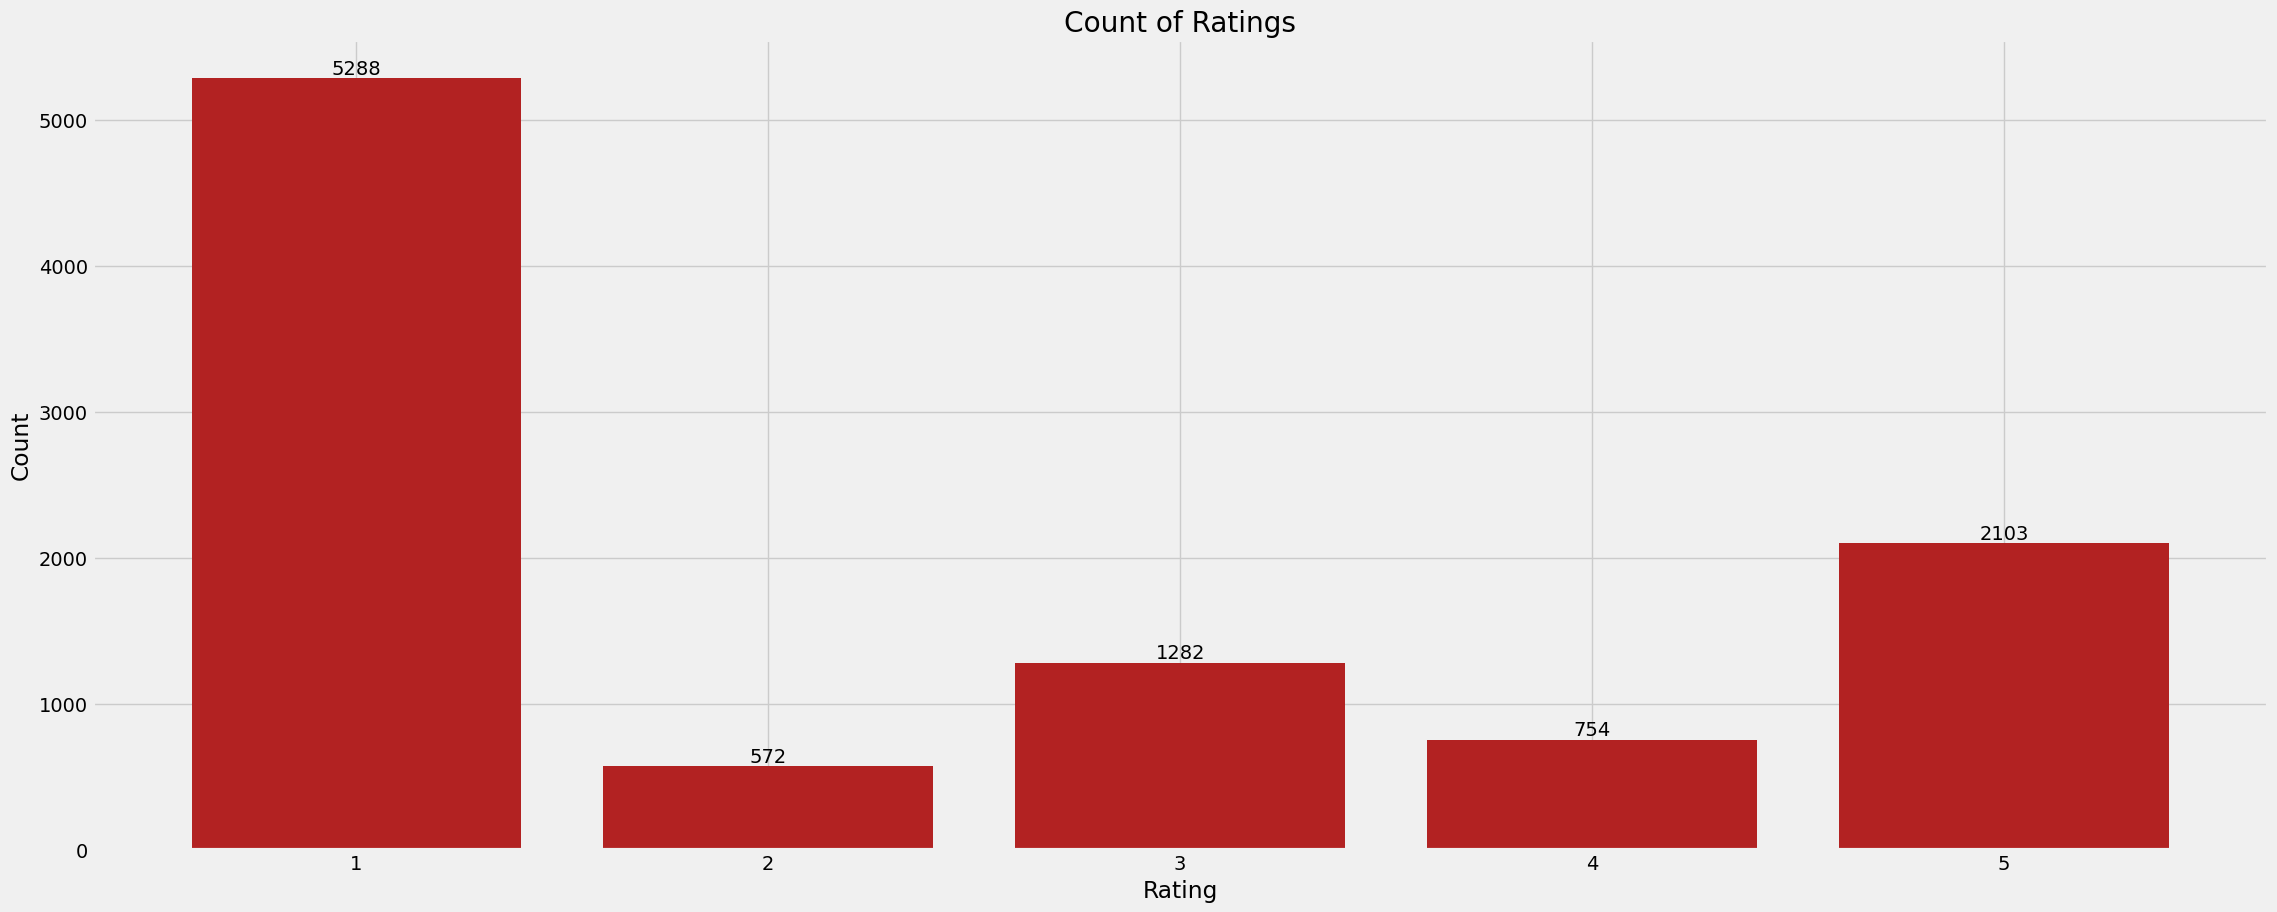

In [16]:
plt.style.use('fivethirtyeight')
fix, ax = plt.subplots(figsize = (25, 10))

ratings = reviews['RATING'].value_counts()
ind = reviews['RATING'].unique()

plt.bar(ind, ratings, color = 'firebrick', align = 'center')

for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2,
            p.get_height(),
            '{:.0f}'.format(p.get_height()),
            ha='center',
            va='bottom'
           )

plt.title('Count of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [17]:
# dataset is unbalanced, but that is ok in our context as we will not be exploring the relationship between variables, just the underlying text

In [18]:
reviews.head()

,ID,REVIEW_DATE,IS_VERIFIED,RATING,REVIEW_TITLE,REVIEW_TEXT,COUNTRY,LANGUAGE
0,3129911,2022-08-17,True,1,This has NO flavor,"This item has no flavor, several people have tried it in my house and all agree it is flavorless. It of course can NOT be returned so I just waisted $15. Don't waste your money on this garbage.",United States,en
1,2702184,2022-06-07,True,1,Different formula,I have used this brand of sunscreen for about 6 years or so. I've never had any problems until this past month when I purchased a new bottle. The new formula doesn't use nonnano zinc as the previous version did. My child and I have been very badly sunburned twice now. It has to be because of the new formula. I'm very upset because I have allergies and sensitive skin. This was the only brand that has ever worked for me. Thinkbaby should be ashamed for not stating the change in ingredients!,United States,en
2,760128,2014-06-03,True,5,Vitex!!!,"Have been using these for at least 20 months and it was the only product that made a difference in what I would call ""personal summers"" :) Won't use anything else.",United States,en
3,760140,2013-11-24,True,5,Stopping hair loss,"Bought this to help fight hair loss along with dong quai, fo-ti; hair, nail, and skin vitamin by gaia and ginseng. My hair started growing back within a month, stopped breaking within a week's time.",United States,en
4,760132,2014-04-10,True,5,coming off of birth control,"this company is one of the best most honest i've come across. what a wonderfull product , this is a life saver when coming off hormonol birth control",United States,en


## Visualizations p2

Text(0.5, 1.0, 'Number of words by review histogram')

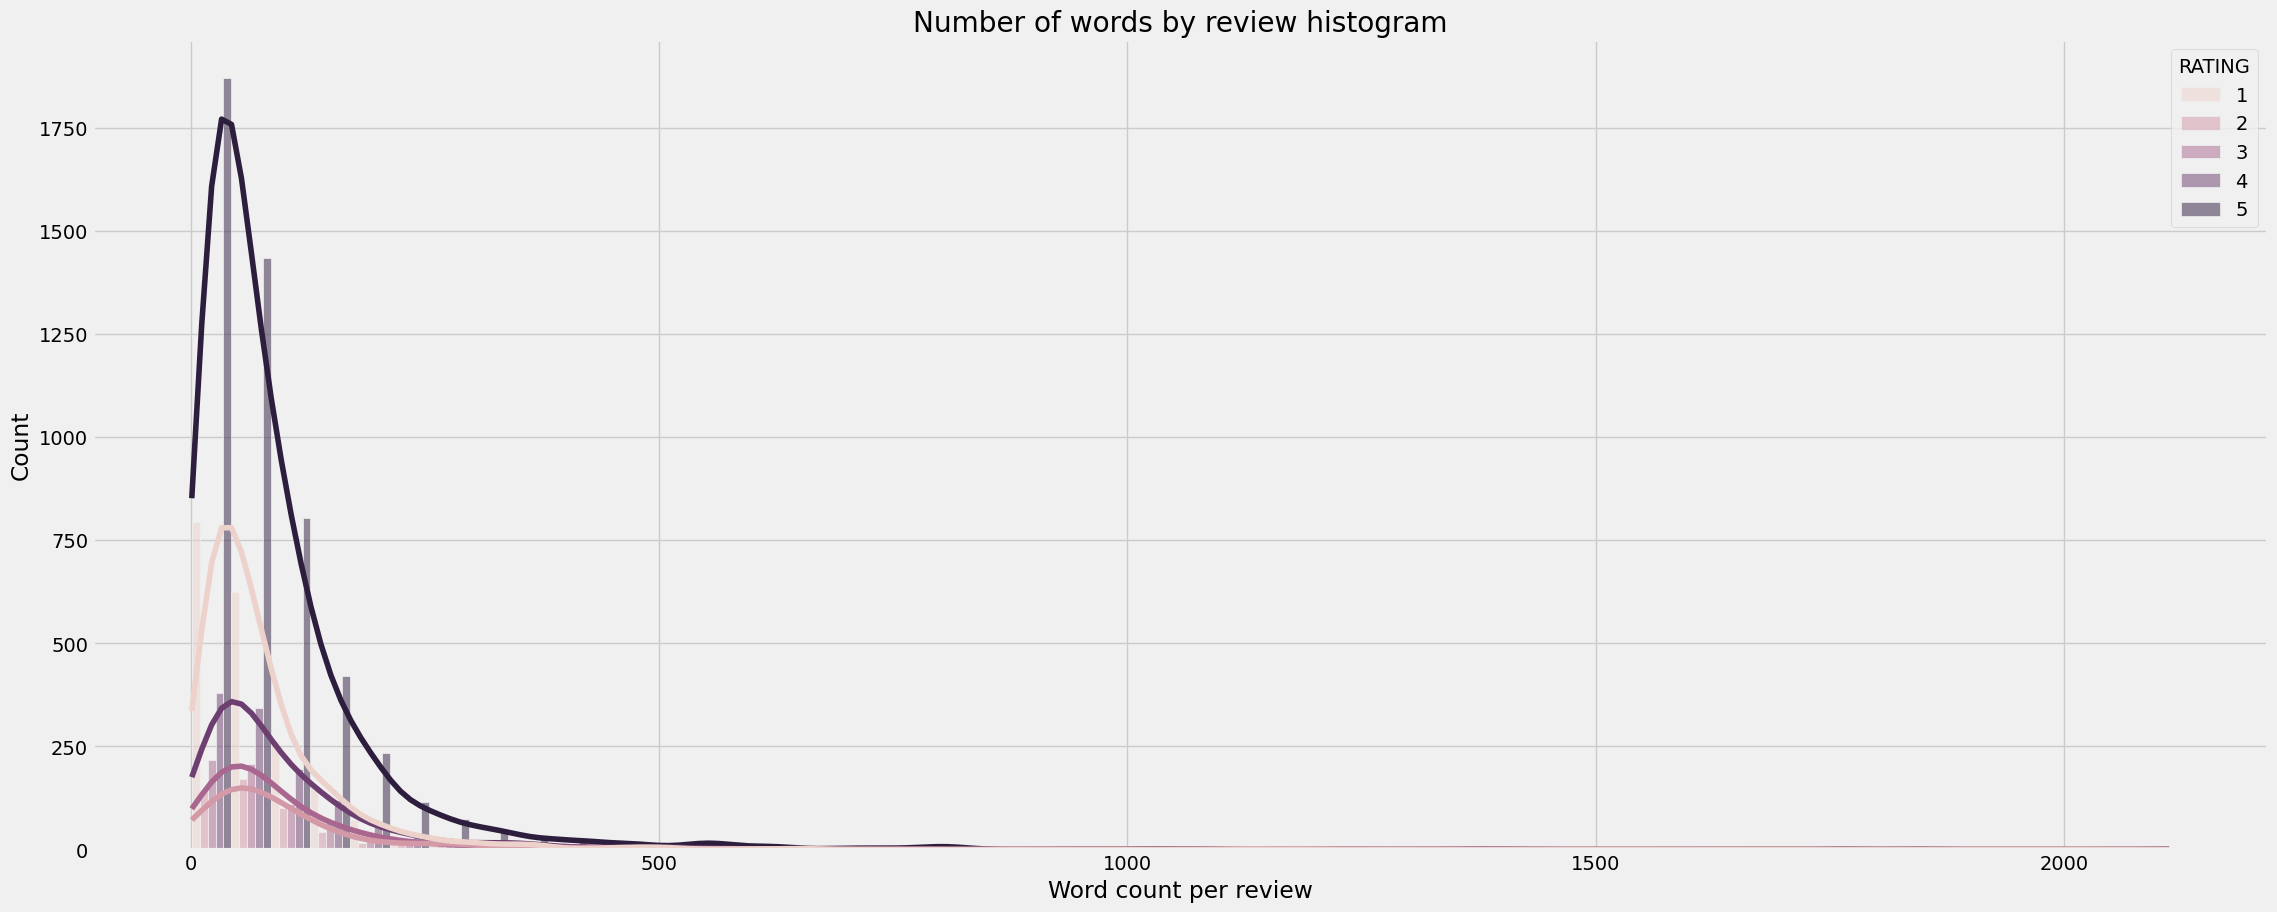

In [19]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize = (25, 10))

sns.histplot(data=english_reviews, x='word_count', hue='RATING', multiple='dodge', legend='RATING', kde = True, bins = 50)

plt.xlabel('Word count per review')
plt.ylabel('Count')
plt.title('Number of words by review histogram')

/var/folders/lr/994tkpld58q9sbf0jsds90h80000gn/T/ipykernel_12766/3030392025.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(data, labels = english_reviews['RATING'].unique(), patch_artist=True)


Text(0, 0.5, 'Word count')

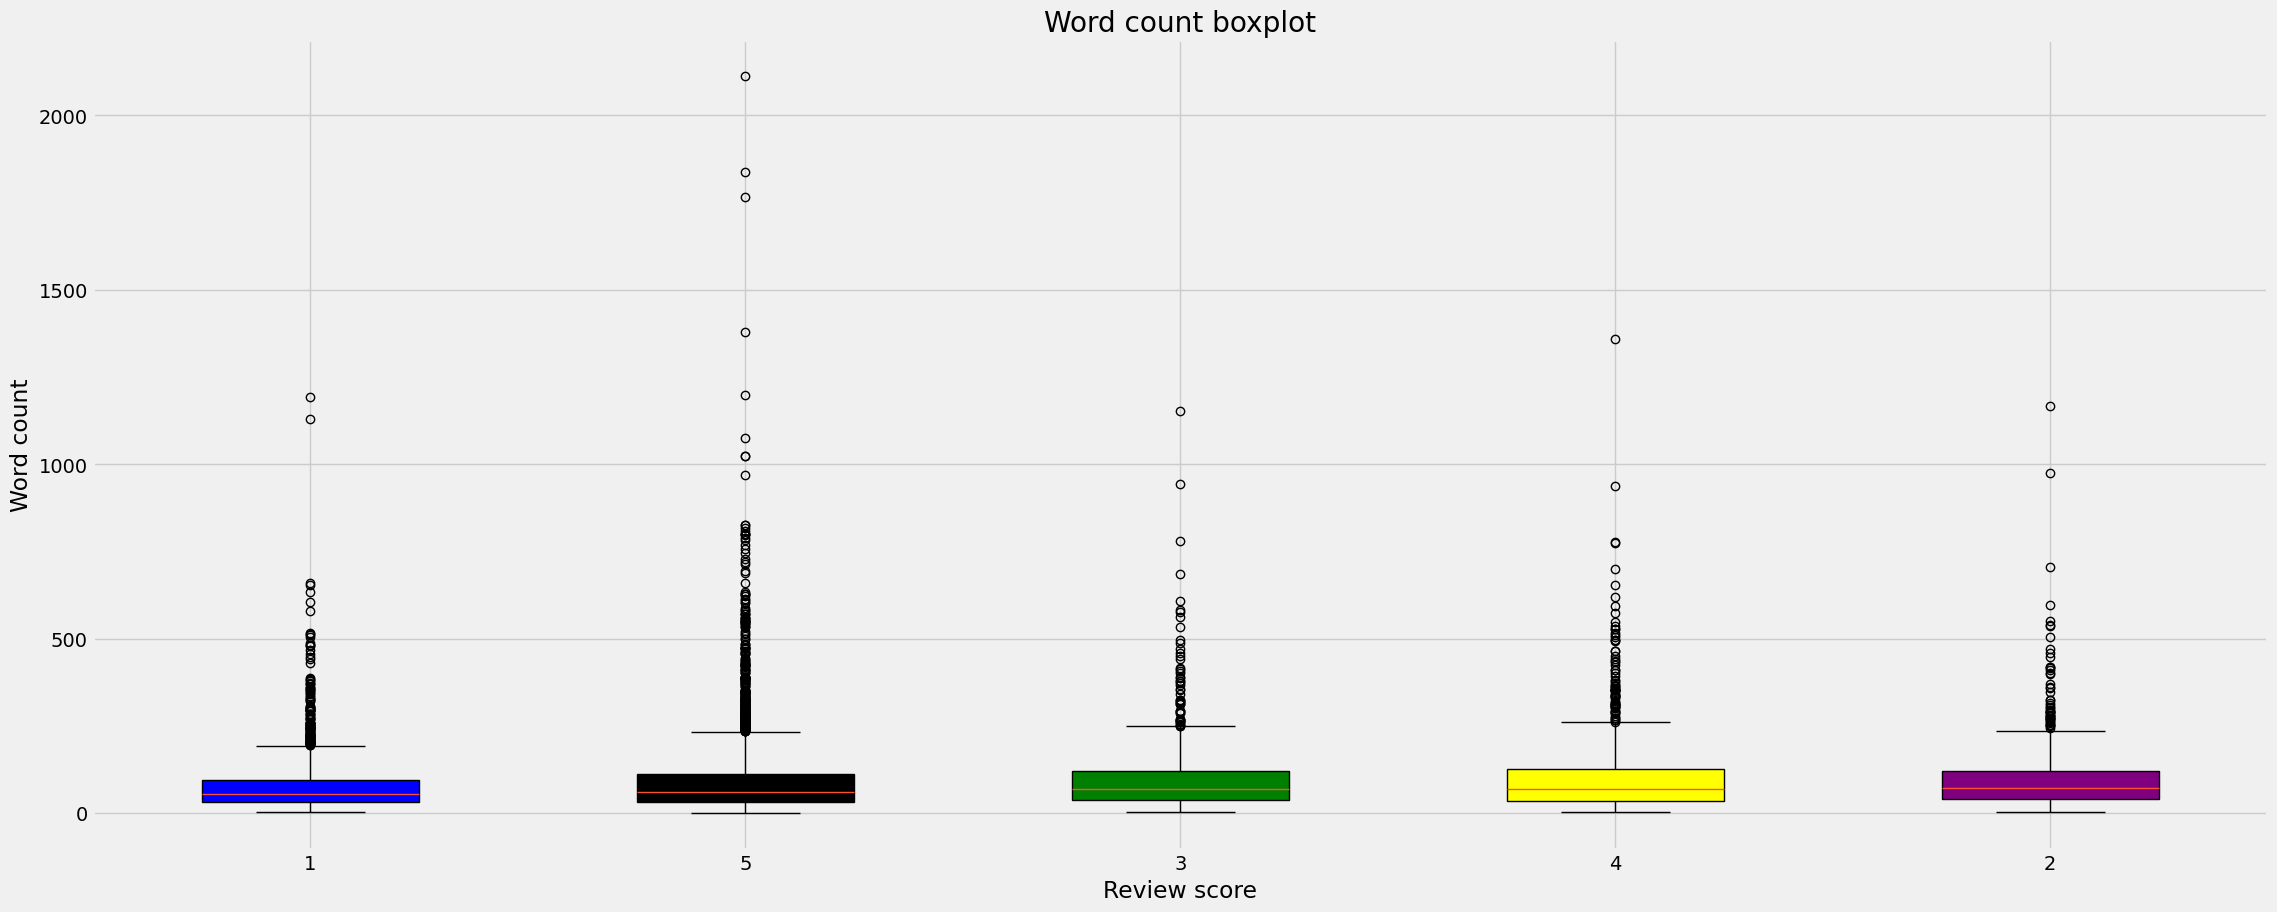

In [20]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize = (25, 10))

wc_group = english_reviews.groupby('RATING')['word_count'].apply(list)
data = [wc_group[cat] for cat in english_reviews['RATING'].unique()]

bp = plt.boxplot(data, labels = english_reviews['RATING'].unique(), patch_artist=True)

colors = ['blue', 'black', 'green', 'yellow', 'purple']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

plt.title('Word count boxplot')
plt.xlabel('Review score')
plt.ylabel('Word count')

In [21]:
## graph of average score over time

In [22]:
pd.set_option('display.max_colwidth', None)
english_reviews['REVIEW_TEXT'].sample(1, random_state = 14)

7318    I was following the new international travel standards for carryon luggage. Although the airline never checked, probably because the plane was not full, I’m sure it would have met the standards. I was very happy with how well the spinner wheels worked as I could handled two of these bags by holding their handles together. And I am amazed at how well my clothes for 3 weeks fit into the bag. (Of course, I did study “how to pack” articles to plan this)
Name: REVIEW_TEXT, dtype: object

In [23]:
# english_reviews_mini = english_reviews[:4800]

# Count Vectorize

In [24]:
def remove_punctuation(text):
    final_text = []
    for row in text:
        clean_row = "".join(u for u in row if u not in ('?', '.', ';', ':', '!', '"', "'", '(', ')', '[', ']', '/', ',', '-', '*'))
        final_text.append(clean_row.lower())
    
    return final_text

In [25]:
token = RegexpTokenizer(f'[a-zA-Z0-9]+')

In [26]:
english_reviews['REVIEW_TEXT'] = remove_punctuation(english_reviews['REVIEW_TEXT'])

/var/folders/lr/994tkpld58q9sbf0jsds90h80000gn/T/ipykernel_12766/2641748750.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_reviews['REVIEW_TEXT'] = remove_punctuation(english_reviews['REVIEW_TEXT'])


In [27]:
cv = CountVectorizer(stop_words = 'english', ngram_range = (1,2), tokenizer = token.tokenize)

In [28]:
text_counts = cv.fit_transform(english_reviews['REVIEW_TEXT'])

/Users/cman/Desktop/code/customer_reviews/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


# Train Test Split P2

In [29]:
X_train, X_test, Y_train, Y_test = train_test_split(text_counts, english_reviews['RATING'], test_size = 0.2, random_state = 42, stratify=english_reviews['RATING'])

# Training the MNB model 

In [30]:
MNB = MultinomialNB()
MNB.fit(X_train, Y_train)

MultinomialNB()

In [31]:
predicted = MNB.predict(X_test)

In [32]:
acc_score = accuracy_score(predicted, Y_test)

In [33]:
print(f'The accuracy score of the Multimodial Naive Bayes model is: {round(acc_score, 2)}')

The accuracy score of the Multimodial Naive Bayes model is: 0.61


In [34]:
predicted[:5]

array([1, 5, 5, 5, 5])

In [35]:
Y_test[:5]

6288    1
4944    5
6319    2
7425    5
1585    5
Name: RATING, dtype: int64

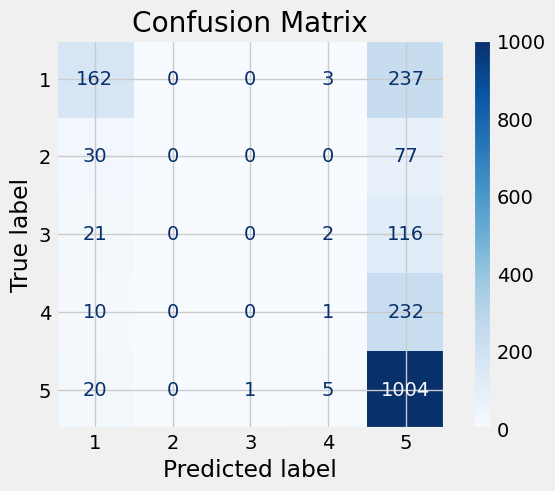

In [36]:
cm = confusion_matrix(Y_test, predicted)

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = np.unique(Y_test))
disp.plot(cmap = plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

## Text blob

Polartiy determines the sentiment of the text. -1 = highly negative review and 1 denotes a highly positive sentiment.

Subjectivity determines whether a text input is fact vs personal information. 0 denotes a fact and 1 denotes a personal opinion.

In [37]:
english_reviews['REVIEW_TEXT'].iloc[284]

'almost 2 months later abused daily and the 11 month old 90+ lb rottweiler puppy still hasnt made a dent in the kong tire no longer pleasantly surprised  amazingly surprisedi have a 10 month old rottweiler puppy that is a strong chewer he has destroyed 2 of the 10 inch pet store tire chews ive always had great experiences with kong products so i ordered this i picked the biggest one they had knowing that kong isnt afraid to make big dog toyswhen i received the tire and saw it was really no bigger than a good doughnut i was pssed to say the least being mail order i figured returning it would be more trouble than it was worth so i gave it to himhe loves it and can not destroy it i guess its big enough that it entices him but not big enough for him to get to its weak areas and destroy it i have not had a tire toy last this long at all let alone remain in like new conditionthanks kong from us and our little boy'

In [38]:
p1 = TextBlob(english_reviews['REVIEW_TEXT'].iloc[284]).sentiment.polarity
s1 = TextBlob(english_reviews['REVIEW_TEXT'].iloc[284]).sentiment.subjectivity

In [39]:
print(f'The polarity of the test token is : {round(p1, 4)} and the subjectivity of the test token is: {round(s1, 4)}')

The polarity of the test token is : 0.0725 and the subjectivity of the test token is: 0.3789


In [40]:
print(f'The actual rating was: {english_reviews['RATING'].iloc[284]}')

The actual rating was: 5


In [41]:
def calculate_polarity(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

def calculate_subjectivity(text):
    blob = TextBlob(text)
    return blob.sentiment.subjectivity

In [42]:
english_reviews['TEXT_BLOB_POLARITY_RAW'] = english_reviews['REVIEW_TEXT'].apply(calculate_polarity)
english_reviews['TEXT_BLOB_SUBJECTIVITY_RAW'] = english_reviews['REVIEW_TEXT'].apply(calculate_subjectivity)

/var/folders/lr/994tkpld58q9sbf0jsds90h80000gn/T/ipykernel_12766/1677028977.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_reviews['TEXT_BLOB_POLARITY_RAW'] = english_reviews['REVIEW_TEXT'].apply(calculate_polarity)
/var/folders/lr/994tkpld58q9sbf0jsds90h80000gn/T/ipykernel_12766/1677028977.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_reviews['TEXT_BLOB_SUBJECTIVITY_RAW'] = english_reviews['REVIEW_TEXT'].apply(calculate_subjectivity)


In [43]:
def map_rating(value):
    mapped_value = (value + 1) * 2.5 + 0.5
    mapped_rating = round(mapped_value)
    mapped_rating = max(1, min(5, mapped_rating))
    return mapped_rating

In [44]:
english_reviews['TEXT_BLOB_POLARITY_MAPPED'] = english_reviews['TEXT_BLOB_POLARITY_RAW'].apply(map_rating)

/var/folders/lr/994tkpld58q9sbf0jsds90h80000gn/T/ipykernel_12766/441747895.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_reviews['TEXT_BLOB_POLARITY_MAPPED'] = english_reviews['TEXT_BLOB_POLARITY_RAW'].apply(map_rating)


In [45]:
english_reviews.head()

,ID,REVIEW_DATE,IS_VERIFIED,RATING,REVIEW_TITLE,REVIEW_TEXT,COUNTRY,LANGUAGE,word_count,TEXT_BLOB_POLARITY_RAW,TEXT_BLOB_SUBJECTIVITY_RAW,TEXT_BLOB_POLARITY_MAPPED
0,3129911,2022-08-17,True,1,This has NO flavor,this item has no flavor several people have tried it in my house and all agree it is flavorless it of course can not be returned so i just waisted $15 dont waste your money on this garbage,United States,en,38,-0.10000,0.000000,3
1,2702184,2022-06-07,True,1,Different formula,i have used this brand of sunscreen for about 6 years or so ive never had any problems until this past month when i purchased a new bottle the new formula doesnt use nonnano zinc as the previous version did my child and i have been very badly sunburned twice now it has to be because of the new formula im very upset because i have allergies and sensitive skin this was the only brand that has ever worked for me thinkbaby should be ashamed for not stating the change in ingredients,United States,en,92,-0.06862,0.538552,3
2,760128,2014-06-03,True,5,Vitex!!!,have been using these for at least 20 months and it was the only product that made a difference in what i would call personal summers wont use anything else,United States,en,31,-0.10000,0.566667,3
3,760140,2013-11-24,True,5,Stopping hair loss,bought this to help fight hair loss along with dong quai foti hair nail and skin vitamin by gaia and ginseng my hair started growing back within a month stopped breaking within a weeks time,United States,en,35,0.00000,0.000000,3
4,760132,2014-04-10,True,5,coming off of birth control,this company is one of the best most honest ive come across what a wonderfull product this is a life saver when coming off hormonol birth control,United States,en,28,0.70000,0.566667,5


In [46]:
english_reviews['TEXT_BLOB_POLARITY_MAPPED'].values

array([3, 3, 3, ..., 4, 3, 5])

In [47]:
english_reviews['RATING'].values

array([1, 1, 5, ..., 5, 5, 5])

In [48]:
acc_score_2 = accuracy_score(english_reviews['TEXT_BLOB_POLARITY_MAPPED'].values, english_reviews['RATING'].values)

In [49]:
print(f'The accuracy score of the \'Text Blob\' model accuracy score is: {round(acc_score_2, 4)}')

The accuracy score of the 'Text Blob' accuracy score is: 0.1327


# VADER

In [53]:
sentiment = SentimentIntensityAnalyzer()


In [54]:
t_1 = english_reviews['REVIEW_TEXT'].iloc[1336]
t_1

'i used to buy these at whole foods and found them on amazon at a much better price these are organic food based vitamins the best vitamins that you can buy they are made from food they are not synthetic vitamins'

In [55]:
sent_1 = sentiment.polarity_scores(t_1)
print(f'The sentiment of review 1337 is : {sent_1}')

The sentiment of review 1337 is : {'neg': 0.0, 'neu': 0.812, 'pos': 0.188, 'compound': 0.8316}
